# 🎬 Humanoid Walking - MoCap Imitation (TRUE DeepMimic) - MULTI-SUBJECT

Train a humanoid to walk by **imitating motion capture data** from the CMU MoCap database.

### Data Sources (6 subjects):
| File | Subject | Description |
|------|---------|-------------|
| `02_01.amc` | Subject 2 | Normal walking |
| `05_01.amc` | Subject 5 | Normal walking |
| `06_01.amc` | Subject 6 | Normal walking |
| `07_03.amc` | Subject 7 | Walking trial 3 |
| `10_04.amc` | Subject 10 | Walking trial 4 |
| `12_01.amc` | Subject 12 | Normal walking |

### How TRUE DeepMimic Works:
```
On each episode reset:
   1. Randomly SELECT one motion clip from the library
   2. Start at a RANDOM PHASE within that clip (RSI)
   3. Robot learns to imitate THAT style for this episode
   
This teaches ROBUST walking from variety - no averaging!
```

### Key Insight:
❌ **Don't AVERAGE subjects** - creates impossible poses  
✅ **SAMPLE from subjects** - learns robust variety

### Reward Structure:
| Reward | Weight | Purpose |
|--------|--------|---------|
| **Healthy (Alive)** | 3.0 | Survival is #1 priority |
| **Forward Progress** | 2.0 | Walk at ~1.4 m/s |
| **Pose Matching** | 2.0 | Match joint angles to reference |
| **Root Position** | 1.5 | Stay upright |
| **End Effector** | 1.0 | Feet in correct positions |
| **Velocity Matching** | 0.5 | Match joint velocities |
| **Arm Swing** | 0.5 | Arms swing opposite to legs |

In [1]:
# Setup CUDA library paths for JAX GPU support
import os
import sys
import ctypes
import glob

nvidia_base = None
for path in sys.path:
    potential_nvidia = os.path.join(path, 'nvidia')
    if os.path.exists(potential_nvidia) and os.path.isdir(potential_nvidia):
        nvidia_base = potential_nvidia
        print(f"Found nvidia packages at: {nvidia_base}")
        break

if nvidia_base:
    lib_dirs = glob.glob(f"{nvidia_base}/*/lib")
    
    if lib_dirs:
        current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld_path = ':'.join(lib_dirs)
        if current_ld_path:
            new_ld_path = f"{new_ld_path}:{current_ld_path}"
        os.environ['LD_LIBRARY_PATH'] = new_ld_path
        
        preloaded = []
        for lib_dir in lib_dirs:
            for lib_name in ['libcudart.so.12', 'libcublas.so.12', 'libcublasLt.so.12']:
                lib_path = os.path.join(lib_dir, lib_name)
                if os.path.exists(lib_path):
                    try:
                        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
                        preloaded.append(lib_name)
                    except Exception as e:
                        print(f"Warning loading {lib_name}: {e}")
        
        print(f"✓ Set LD_LIBRARY_PATH with {len(lib_dirs)} CUDA directories")
        print(f"✓ Preloaded {len(set(preloaded))} CUDA libraries")
    else:
        print(f"⚠ Found nvidia directory but no lib subdirectories")
else:
    print("⚠ Could not find nvidia CUDA packages in sys.path")

Found nvidia packages at: /mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/nvidia
✓ Set LD_LIBRARY_PATH with 12 CUDA directories
✓ Preloaded 3 CUDA libraries


In [2]:
# Check GPU availability
import jax
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX version: 0.8.2
Available devices: [CudaDevice(id=0)]
Default backend: gpu


In [3]:
# Imports
import numpy as np
from pathlib import Path
from jax import numpy as jp
import jax.numpy as jnp
from brax import envs
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


## Step 1: Parse CMU MoCap Data

In [4]:
# Parse CMU MoCap Data (ASF/AMC files) - ALL SUBJECTS

MOCAP_DIR = Path("/mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/Training_Data")

# All available walking data files
MOCAP_FILES = [
    ("02.asf", "02_01.amc"),  # Subject 2 - normal walk
    ("05.asf", "05_01.amc"),  # Subject 5
    ("06.asf", "06_01.amc"),  # Subject 6
    ("07.asf", "07_03.amc"),  # Subject 7 (trial 3)
    ("10.asf", "10_04.amc"),  # Subject 10 (trial 4)
    ("12.asf", "12_01.amc"),  # Subject 12
]

print("="*70)
print("📄 Parsing CMU MoCap Data - MULTI-SUBJECT")
print("="*70)
print(f"Found {len(MOCAP_FILES)} walking sequences:")

class ASFParser:
    """Parse CMU ASF (Acclaim Skeleton File) format."""
    
    def __init__(self, filepath):
        self.bones = {}
        self.hierarchy = {}
        self.root_order = []
        self.parse(filepath)
    
    def parse(self, filepath):
        with open(filepath, 'r') as f:
            content = f.read()
        
        sections = {}
        current_section = None
        current_content = []
        
        for line in content.split('\n'):
            line = line.strip()
            if line.startswith(':'):
                if current_section:
                    sections[current_section] = '\n'.join(current_content)
                current_section = line[1:].split()[0]
                current_content = []
            elif current_section:
                current_content.append(line)
        
        if current_section:
            sections[current_section] = '\n'.join(current_content)
        
        if 'bonedata' in sections:
            self._parse_bones(sections['bonedata'])
        if 'hierarchy' in sections:
            self._parse_hierarchy(sections['hierarchy'])
        if 'root' in sections:
            for line in sections['root'].split('\n'):
                if line.startswith('order'):
                    self.root_order = line.split()[1:]
    
    def _parse_bones(self, content):
        current_bone = None
        for line in content.split('\n'):
            parts = line.split()
            if not parts:
                continue
            if parts[0] == 'begin':
                current_bone = {}
            elif parts[0] == 'end':
                if current_bone and 'name' in current_bone:
                    self.bones[current_bone['name']] = current_bone
                current_bone = None
            elif current_bone is not None:
                if parts[0] == 'name':
                    current_bone['name'] = parts[1]
                elif parts[0] == 'dof':
                    current_bone['dof'] = parts[1:]
    
    def _parse_hierarchy(self, content):
        for line in content.split('\n'):
            parts = line.split()
            if len(parts) >= 2 and parts[0] not in ['begin', 'end']:
                self.hierarchy[parts[0]] = parts[1:]


class AMCParser:
    """Parse CMU AMC (Acclaim Motion Capture) format."""
    
    def __init__(self, filepath):
        self.frames = []
        self.parse(filepath)
    
    def parse(self, filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        current_frame = None
        
        for line in lines:
            line = line.strip()
            if not line or line.startswith('#') or line.startswith(':'):
                continue
            
            parts = line.split()
            
            if len(parts) == 1 and parts[0].isdigit():
                if current_frame is not None:
                    self.frames.append(current_frame)
                current_frame = {'frame': int(parts[0])}
            elif current_frame is not None and len(parts) >= 2:
                bone_name = parts[0]
                values = [float(x) for x in parts[1:]]
                current_frame[bone_name] = values
        
        if current_frame is not None:
            self.frames.append(current_frame)


# Parse the files - ALL SUBJECTS
all_motions = []

for asf_name, amc_name in MOCAP_FILES:
    asf_file = MOCAP_DIR / asf_name
    amc_file = MOCAP_DIR / amc_name
    
    if not asf_file.exists() or not amc_file.exists():
        print(f"  ⚠ Skipping {amc_name} (file not found)")
        continue
    
    print(f"\n  📁 {amc_name}:")
    asf = ASFParser(asf_file)
    amc = AMCParser(amc_file)
    all_motions.append({
        'name': amc_name,
        'asf': asf,
        'amc': amc,
        'frames': amc.frames
    })
    print(f"     {len(amc.frames)} frames ({len(amc.frames)/120:.1f}s)")

print(f"\n✅ Loaded {len(all_motions)} walking sequences")
total_frames = sum(len(m['frames']) for m in all_motions)
print(f"   Total frames: {total_frames} ({total_frames/120:.1f} seconds)")

📄 Parsing CMU MoCap Data - MULTI-SUBJECT
Found 6 walking sequences:

  📁 02_01.amc:
     343 frames (2.9s)

  📁 05_01.amc:
     598 frames (5.0s)

  📁 06_01.amc:
     494 frames (4.1s)

  📁 07_03.amc:
     415 frames (3.5s)

  📁 10_04.amc:
     549 frames (4.6s)

  📁 12_01.amc:
     523 frames (4.4s)

✅ Loaded 6 walking sequences
   Total frames: 2922 (24.4 seconds)


## Step 2: Extract Walking Cycle & Map to Brax Joints

In [ ]:
# Extract Walking Cycle & Map to Brax Humanoid Joints

print("="*70)
print("🔄 Extracting Walking Reference Motion")
print("="*70)

def extract_joint_angles(frame):
    """Extract joint angles from a single AMC frame.
    
    CMU MoCap coordinate system:
    - X: right (lateral)
    - Y: up (vertical)  
    - Z: forward (anterior)
    
    Brax humanoid coordinate system:
    - X: forward
    - Y: left
    - Z: up
    
    We need to remap and flip signs accordingly!
    """
    pose = {}
    
    # Root position and rotation (CMU uses inches and degrees)
    if 'root' in frame:
        root = frame['root']
        # Position: CMU (X=right, Y=up, Z=forward) → Brax (X=forward, Y=left, Z=up)
        pose['root_x'] = root[2] * 0.0254   # CMU Z → Brax X (forward)
        pose['root_y'] = -root[0] * 0.0254  # CMU -X → Brax Y (left)
        pose['root_z'] = root[1] * 0.0254   # CMU Y → Brax Z (up)
        # Rotations also need remapping
        pose['root_rx'] = np.radians(root[5])   # CMU rz → Brax rx
        pose['root_ry'] = np.radians(-root[3])  # CMU -rx → Brax ry
        pose['root_rz'] = np.radians(root[4])   # CMU ry → Brax rz
    
    # Left leg - CMU femur rotations need axis swapping
    if 'lfemur' in frame:
        # CMU: (rx, ry, rz) where rx is flexion, ry is abduction, rz is rotation
        # Brax left_hip: (x=lateral, z=rotation, y=flexion)
        pose['left_hip_x'] = np.radians(-frame['lfemur'][1])  # Abduction (flip sign for left)
        pose['left_hip_z'] = np.radians(-frame['lfemur'][2])  # Rotation
        pose['left_hip_y'] = np.radians(-frame['lfemur'][0])  # Flexion (negative = forward)
    if 'ltibia' in frame:
        pose['left_knee'] = np.radians(frame['ltibia'][0])    # Knee flexion
    
    # Right leg
    if 'rfemur' in frame:
        pose['right_hip_x'] = np.radians(frame['rfemur'][1])  # Abduction
        pose['right_hip_z'] = np.radians(frame['rfemur'][2])  # Rotation
        pose['right_hip_y'] = np.radians(-frame['rfemur'][0]) # Flexion (negative = forward)
    if 'rtibia' in frame:
        pose['right_knee'] = np.radians(frame['rtibia'][0])   # Knee flexion
    
    # Spine/Torso - need to swap axes
    if 'lowerback' in frame:
        lb = frame['lowerback']
        pose['abdomen_y'] = np.radians(lb[0]) if len(lb) > 0 else 0  # Forward bend
        pose['abdomen_z'] = np.radians(lb[2]) if len(lb) > 2 else 0  # Twist
        pose['abdomen_x'] = np.radians(lb[1]) if len(lb) > 1 else 0  # Side bend
    
    # Left arm
    if 'lhumerus' in frame:
        lh = frame['lhumerus']
        # Shoulder: CMU (rx, ry, rz) → Brax (shoulder1=y rotation, shoulder2=x rotation)
        pose['left_shoulder1'] = np.radians(-lh[1]) if len(lh) > 1 else 0  # Arm forward/back
        pose['left_shoulder2'] = np.radians(-lh[0]) if len(lh) > 0 else 0  # Arm out/in
    if 'lradius' in frame:
        pose['left_elbow'] = np.radians(frame['lradius'][0])
    
    # Right arm
    if 'rhumerus' in frame:
        rh = frame['rhumerus']
        pose['right_shoulder1'] = np.radians(-rh[1]) if len(rh) > 1 else 0
        pose['right_shoulder2'] = np.radians(rh[0]) if len(rh) > 0 else 0
    if 'rradius' in frame:
        pose['right_elbow'] = np.radians(frame['rradius'][0])
    
    return pose


# Brax humanoid joint order (17 actuated DOFs)
BRAX_JOINTS = [
    'abdomen_y', 'abdomen_z', 'abdomen_x',
    'right_hip_x', 'right_hip_z', 'right_hip_y', 'right_knee',
    'left_hip_x', 'left_hip_z', 'left_hip_y', 'left_knee',
    'right_shoulder1', 'right_shoulder2', 'right_elbow',
    'left_shoulder1', 'left_shoulder2', 'left_elbow',
]

# Direct mapping - now using corrected joint names
CMU_TO_BRAX = {
    'abdomen_y': 0, 'abdomen_z': 1, 'abdomen_x': 2,
    'right_hip_x': 3, 'right_hip_z': 4, 'right_hip_y': 5, 'right_knee': 6,
    'left_hip_x': 7, 'left_hip_z': 8, 'left_hip_y': 9, 'left_knee': 10,
    'right_shoulder1': 11, 'right_shoulder2': 12, 'right_elbow': 13,
    'left_shoulder1': 14, 'left_shoulder2': 15, 'left_elbow': 16,
}

def frames_to_brax_reference(frames, start_frame=50, num_frames=120):
    """Convert AMC frames to Brax joint angle array."""
    reference = np.zeros((num_frames, 17))
    
    for i in range(num_frames):
        frame_idx = start_frame + i
        if frame_idx >= len(frames):
            frame_idx = frame_idx % len(frames)
        
        pose = extract_joint_angles(frames[frame_idx])
        
        for cmu_joint, brax_idx in CMU_TO_BRAX.items():
            if cmu_joint in pose:
                reference[i, brax_idx] = pose[cmu_joint]
    
    return reference


# Extract walking cycles from ALL SUBJECTS
print("\n" + "="*70)
print("🔄 Extracting Walking Cycles from All Subjects")
print("="*70)

all_references = []
cycle_frames = 120  # ~1 second at 120 FPS per subject

for motion_data in all_motions:
    frames = motion_data['frames']
    name = motion_data['name']
    
    # Extract multiple walking cycles from each sequence
    # Skip first 50 frames (usually settling), take cycles every 100 frames
    num_cycles = max(1, (len(frames) - 100) // 100)
    
    for cycle_idx in range(min(num_cycles, 5)):  # Max 5 cycles per subject
        start = 50 + cycle_idx * 100
        if start + cycle_frames > len(frames):
            break
        
        ref = frames_to_brax_reference(frames, start, cycle_frames)
        all_references.append(ref)
        print(f"  ✓ {name}: cycle {cycle_idx+1} (frames {start}-{start+cycle_frames})")

print(f"\n📊 Extracted {len(all_references)} walking cycles total")

# Stack all references and compute AVERAGE walking pattern
stacked_refs = np.stack(all_references, axis=0)  # (num_cycles, 120, 17)
mean_reference = np.mean(stacked_refs, axis=0)   # (120, 17) - average walk

# Also keep all cycles for variety during training
all_cycles_flat = np.concatenate(all_references, axis=0)  # (num_cycles * 120, 17)

print(f"   Mean reference shape: {mean_reference.shape}")
print(f"   All cycles shape: {all_cycles_flat.shape}")

# Resample MEAN to Brax timestep (~67 FPS, dt=0.015)
cmu_fps = 120
brax_fps = 1.0 / 0.015  # ~66.67 FPS
duration = cycle_frames / cmu_fps
brax_frames = int(duration * brax_fps)

x_cmu = np.linspace(0, 1, cycle_frames)
x_brax = np.linspace(0, 1, brax_frames)

# Create averaged reference motion
REFERENCE_MOTION = np.zeros((brax_frames, 17))
for j in range(17):
    REFERENCE_MOTION[:, j] = np.interp(x_brax, x_cmu, mean_reference[:, j])

REFERENCE_MOTION = jnp.array(REFERENCE_MOTION)

# Also create FULL reference with all cycles concatenated (for variety)
total_brax_frames = int(all_cycles_flat.shape[0] / cmu_fps * brax_fps)
x_cmu_full = np.linspace(0, 1, all_cycles_flat.shape[0])
x_brax_full = np.linspace(0, 1, total_brax_frames)

FULL_REFERENCE_MOTION = np.zeros((total_brax_frames, 17))
for j in range(17):
    FULL_REFERENCE_MOTION[:, j] = np.interp(x_brax_full, x_cmu_full, all_cycles_flat[:, j])

FULL_REFERENCE_MOTION = jnp.array(FULL_REFERENCE_MOTION)

print(f"\n✅ Reference Motions Created:")
print(f"   REFERENCE_MOTION (averaged): {REFERENCE_MOTION.shape} ({REFERENCE_MOTION.shape[0] * 0.015:.2f}s cycle)")
print(f"   FULL_REFERENCE_MOTION (all): {FULL_REFERENCE_MOTION.shape} ({FULL_REFERENCE_MOTION.shape[0] * 0.015:.2f}s total)")

# Show joint ranges from AVERAGED motion
print("\n📊 Joint angle ranges in AVERAGED walking cycle (degrees):")
for j, joint_name in enumerate(BRAX_JOINTS):
    min_val = np.degrees(float(REFERENCE_MOTION[:, j].min()))
    max_val = np.degrees(float(REFERENCE_MOTION[:, j].max()))
    range_val = max_val - min_val
    if range_val > 1:
        print(f"  {joint_name:18s}: {min_val:+6.1f}° to {max_val:+6.1f}° (range: {range_val:.1f}°)")

print(f"\n✓ REFERENCE_MOTION shape: {REFERENCE_MOTION.shape}")

🔄 Extracting Walking Reference Motion

🔄 Extracting Walking Cycles from All Subjects
  ✓ 02_01.amc: cycle 1 (frames 50-170)
  ✓ 02_01.amc: cycle 2 (frames 150-270)
  ✓ 05_01.amc: cycle 1 (frames 50-170)
  ✓ 05_01.amc: cycle 2 (frames 150-270)
  ✓ 05_01.amc: cycle 3 (frames 250-370)
  ✓ 05_01.amc: cycle 4 (frames 350-470)
  ✓ 06_01.amc: cycle 1 (frames 50-170)
  ✓ 06_01.amc: cycle 2 (frames 150-270)
  ✓ 06_01.amc: cycle 3 (frames 250-370)
  ✓ 07_03.amc: cycle 1 (frames 50-170)
  ✓ 07_03.amc: cycle 2 (frames 150-270)
  ✓ 07_03.amc: cycle 3 (frames 250-370)
  ✓ 10_04.amc: cycle 1 (frames 50-170)
  ✓ 10_04.amc: cycle 2 (frames 150-270)
  ✓ 10_04.amc: cycle 3 (frames 250-370)
  ✓ 10_04.amc: cycle 4 (frames 350-470)
  ✓ 12_01.amc: cycle 1 (frames 50-170)
  ✓ 12_01.amc: cycle 2 (frames 150-270)
  ✓ 12_01.amc: cycle 3 (frames 250-370)
  ✓ 12_01.amc: cycle 4 (frames 350-470)

📊 Extracted 20 walking cycles total
   Mean reference shape: (120, 17)
   All cycles shape: (2400, 17)

✅ Reference Moti

## Step 3: Create MoCap-Guided Environment

In [11]:
# MoCap-Guided Environment (DeepMimic-style) - MULTI-SUBJECT SAMPLING

from brax.envs.base import PipelineEnv, State

class MoCapHumanoid(PipelineEnv):
    """Humanoid trained to imitate MoCap reference motion from MULTIPLE subjects.
    
    Uses the TRUE DeepMimic approach:
    1. On reset: randomly select ONE motion clip from the library
    2. Start at a random phase within that clip (RSI)
    3. Robot learns to imitate ANY of the walking styles
    4. This teaches robust walking without averaging impossible poses
    
    Key insight: Don't AVERAGE subjects (creates impossible poses).
    Instead, SAMPLE from them randomly during training!
    """
    
    def __init__(
        self,
        reference_motions: jnp.ndarray,       # Shape: (num_clips, frames, joints)
        pose_reward_weight: float = 2.0,
        velocity_reward_weight: float = 0.5,
        end_effector_weight: float = 1.0,
        root_reward_weight: float = 1.5,
        forward_reward_weight: float = 2.0,
        arm_swing_reward_weight: float = 0.5,
        healthy_reward: float = 3.0,
        ctrl_cost_weight: float = 0.01,
        terminate_when_unhealthy: bool = True,
        healthy_z_range: tuple = (0.5, 2.1),
        reset_noise_scale: float = 0.005,
        use_reference_init: bool = True,
        backend: str = 'generalized',
        **kwargs,
    ):
        from brax.io import mjcf
        from etils import epath
        
        path = epath.resource_path('brax') / 'envs/assets/humanoid.xml'
        sys = mjcf.load(path)
        
        kwargs['n_frames'] = kwargs.get('n_frames', 5)
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        # Store ALL motion clips (num_clips, frames, joints)
        self._reference_motions = reference_motions
        self._num_clips = reference_motions.shape[0]
        self._num_ref_frames = reference_motions.shape[1]
        self._cycle_duration = self._num_ref_frames * self.dt
        
        self._pose_reward_weight = pose_reward_weight
        self._velocity_reward_weight = velocity_reward_weight
        self._end_effector_weight = end_effector_weight
        self._root_reward_weight = root_reward_weight
        self._forward_reward_weight = forward_reward_weight
        self._arm_swing_reward_weight = arm_swing_reward_weight
        self._healthy_reward = healthy_reward
        self._ctrl_cost_weight = ctrl_cost_weight
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        self._use_reference_init = use_reference_init
        
        # Body indices
        self._torso_idx = 0
        self._right_foot_idx = 5
        self._left_foot_idx = 8
        self._right_upper_arm_idx = 9
        self._left_upper_arm_idx = 11
        self._right_thigh_idx = 3
        self._left_thigh_idx = 6
        
    def reset(self, rng: jax.Array) -> State:
        rng, rng1, rng2, rng3, rng_clip = jax.random.split(rng, 5)
        
        # MULTI-SUBJECT: Randomly select which motion clip to use this episode
        clip_idx = jax.random.randint(rng_clip, (), 0, self._num_clips)
        current_motion = self._reference_motions[clip_idx]
        
        # Start with default pose
        qpos = self.sys.init_q.copy()
        
        # Reference State Initialization (RSI): Start at random phase
        if self._use_reference_init:
            # Pick a random starting phase within the selected clip
            init_phase = jax.random.uniform(rng3, minval=0.0, maxval=1.0)
            frame_idx = (init_phase * self._num_ref_frames).astype(jp.int32)
            frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)
            ref_pose = current_motion[frame_idx]
            
            # Set joint angles to reference (q[7:] are joint angles)
            num_joints = min(len(qpos) - 7, 17)
            qpos = qpos.at[7:7+num_joints].set(ref_pose[:num_joints])
        else:
            init_phase = jp.array(0.0)
            ref_pose = current_motion[0]
        
        # Add small noise
        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        qpos = qpos + jax.random.uniform(rng1, qpos.shape, minval=low, maxval=hi)
        
        # Small initial velocity
        qvel = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=low, maxval=hi
        )
        
        pipeline_state = self.pipeline_init(qpos, qvel)
        
        phase = init_phase
        step_count = jp.array(0.0)
        
        obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()), phase, ref_pose)
        
        reward, done, zero = jp.zeros(3)
        metrics = {
            'pose_reward': zero,
            'velocity_reward': zero,
            'end_effector_reward': zero,
            'root_reward': zero,
            'forward_reward': zero,
            'arm_swing_reward': zero,
            'reward_alive': zero,
            'reward_ctrl': zero,
            'x_velocity': zero,
            'phase': phase,
            'step_count': step_count,
            'clip_idx': clip_idx.astype(jp.float32),  # Store which clip we're using
        }
        
        return State(pipeline_state, obs, reward, done, metrics)
    
    def step(self, state: State, action: jax.Array) -> State:
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min
        
        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        
        # Get the motion clip selected at reset
        clip_idx = state.metrics['clip_idx'].astype(jp.int32)
        current_motion = self._reference_motions[clip_idx]
        
        # Update phase from metrics
        step_count = state.metrics['step_count'] + 1
        phase = (step_count * self.dt / self._cycle_duration) % 1.0
        
        # Get reference pose for current phase from THIS clip
        frame_idx = (phase * self._num_ref_frames).astype(jp.int32)
        frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)
        ref_pose = current_motion[frame_idx]
        
        # ====== IMITATION REWARDS ======
        
        # 1. POSE REWARD: Match joint angles
        current_joints = pipeline_state.q[7:]
        num_joints = min(len(current_joints), 17)
        
        joint_error = jp.sum(jp.square(current_joints[:num_joints] - ref_pose[:num_joints]))
        pose_reward = self._pose_reward_weight * jp.exp(-2.0 * joint_error)
        
        # 2. VELOCITY REWARD: Match joint velocities
        next_idx = (frame_idx + 1) % self._num_ref_frames
        ref_pose_next = current_motion[next_idx]
        ref_velocity = (ref_pose_next - ref_pose) / self.dt
        
        current_velocity = pipeline_state.qd[6:]
        vel_error = jp.sum(jp.square(current_velocity[:num_joints] - ref_velocity[:num_joints]))
        velocity_reward = self._velocity_reward_weight * jp.exp(-0.1 * vel_error)
        
        # 3. END-EFFECTOR REWARD: Feet contact ground properly
        body_pos = pipeline_state.x.pos
        left_foot_z = body_pos[self._left_foot_idx, 2]
        right_foot_z = body_pos[self._right_foot_idx, 2]
        
        min_foot_height = jp.minimum(left_foot_z, right_foot_z)
        end_effector_reward = self._end_effector_weight * jp.exp(-10.0 * jp.square(min_foot_height))
        
        # 4. ROOT REWARD: Keep torso upright
        torso_z = body_pos[self._torso_idx, 2]
        root_height_reward = jp.exp(-2.0 * jp.square(torso_z - 1.25))
        root_reward = self._root_reward_weight * root_height_reward
        
        # 5. FORWARD REWARD: Actually move forward! (target ~1.4 m/s)
        com_before = self._com(pipeline_state0)
        com_after = self._com(pipeline_state)
        x_velocity = (com_after[0] - com_before[0]) / self.dt
        
        # Gaussian reward around target velocity
        target_velocity = 1.4
        vel_error = jp.abs(x_velocity - target_velocity)
        forward_reward = self._forward_reward_weight * jp.exp(-vel_error**2 / 0.5)
        
        # 6. ARM SWING REWARD: Arms should swing opposite to legs
        body_vel = pipeline_state.xd.vel
        right_arm_vel_x = body_vel[self._right_upper_arm_idx, 0]
        left_arm_vel_x = body_vel[self._left_upper_arm_idx, 0]
        right_leg_vel_x = body_vel[self._right_thigh_idx, 0]
        left_leg_vel_x = body_vel[self._left_thigh_idx, 0]
        
        # Opposite motion = negative correlation = good
        arm_leg_opposition = (
            -right_arm_vel_x * right_leg_vel_x +
            -left_arm_vel_x * left_leg_vel_x
        )
        arm_swing_reward = self._arm_swing_reward_weight * jp.tanh(arm_leg_opposition * 0.5)
        
        # 7. CONTROL COST
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
        
        # 8. HEALTHY REWARD
        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(torso_z < min_z, 0.0, 1.0)
        is_healthy = jp.where(torso_z > max_z, 0.0, is_healthy)
        healthy_reward = self._healthy_reward
        
        reward = (
            pose_reward + velocity_reward + end_effector_reward +
            root_reward + forward_reward + arm_swing_reward +
            healthy_reward - ctrl_cost
        )
        
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        
        obs = self._get_obs(pipeline_state, action, phase, ref_pose)
        
        state.metrics.update(
            pose_reward=pose_reward,
            velocity_reward=velocity_reward,
            end_effector_reward=end_effector_reward,
            root_reward=root_reward,
            forward_reward=forward_reward,
            arm_swing_reward=arm_swing_reward,
            reward_alive=healthy_reward,
            reward_ctrl=-ctrl_cost,
            x_velocity=x_velocity,
            phase=phase,
            step_count=step_count,
            clip_idx=state.metrics['clip_idx'],  # Keep clip_idx for the episode
        )
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
    
    def _get_obs(self, pipeline_state, action, phase, ref_pose) -> jax.Array:
        position = pipeline_state.q[2:]
        velocity = pipeline_state.qd
        
        # Phase as sin/cos for continuity
        phase_obs = jp.array([jp.sin(2 * jp.pi * phase), jp.cos(2 * jp.pi * phase)])
        
        return jp.concatenate([position, velocity, phase_obs, ref_pose])
    
    def _com(self, pipeline_state) -> jax.Array:
        """Calculate center of mass."""
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com


# Create the MoCap environment with MULTI-SUBJECT SAMPLING
print("="*70)
print("🎬 Creating MoCap Environment - TRUE DeepMimic (Multi-Subject)")
print("="*70)

# Resample ALL motion clips to Brax timestep
# Each clip becomes (brax_frames, 17) - then we stack them
print(f"\n📊 Processing {len(all_references)} walking cycles from all subjects...")

brax_frames_per_cycle = int(all_references[0].shape[0] / cmu_fps * brax_fps)
print(f"   CMU frames per cycle: {all_references[0].shape[0]} (at 120 FPS)")
print(f"   Brax frames per cycle: {brax_frames_per_cycle} (at ~67 FPS)")

resampled_clips = []
for i, ref in enumerate(all_references):
    x_cmu = np.linspace(0, 1, ref.shape[0])
    x_brax = np.linspace(0, 1, brax_frames_per_cycle)
    
    resampled = np.zeros((brax_frames_per_cycle, 17))
    for j in range(17):
        resampled[:, j] = np.interp(x_brax, x_cmu, np.array(ref[:, j]))
    resampled_clips.append(resampled)

# Stack into (num_clips, frames, joints)
MOTION_LIBRARY = jnp.array(np.stack(resampled_clips, axis=0))
print(f"\n✅ Motion Library Created!")
print(f"   Shape: {MOTION_LIBRARY.shape} (clips, frames, joints)")
print(f"   Total walking cycles: {MOTION_LIBRARY.shape[0]}")

mocap_env = MoCapHumanoid(
    reference_motions=MOTION_LIBRARY,  # ALL clips - samples randomly!
    pose_reward_weight=2.0,
    velocity_reward_weight=0.5,
    end_effector_weight=1.0,
    root_reward_weight=1.5,
    forward_reward_weight=2.0,
    arm_swing_reward_weight=0.5,
    healthy_reward=3.0,
    ctrl_cost_weight=0.01,
    healthy_z_range=(0.5, 2.1),
    use_reference_init=True,           # Start from reference pose
    backend='generalized'
)

print(f"\n✅ MoCapHumanoid Environment Created!")
print(f"   Motion library: {MOTION_LIBRARY.shape[0]} clips × {MOTION_LIBRARY.shape[1]} frames")
print(f"   Each episode: randomly samples ONE clip from the library")
print(f"   RSI: starts at random phase within that clip")
print(f"   Observation size: {mocap_env.observation_size}")
print(f"   Action size: {mocap_env.action_size}")
print(f"\n   🎯 TRUE DeepMimic approach:")
print(f"   • Does NOT average subjects (that creates impossible poses)")
print(f"   • SAMPLES randomly from the library each episode")
print(f"   • Robot learns robust walking from variety of styles")
print(f"\n   Reward structure:")
print(f"   • forward        = 2.0  (walk at ~1.4 m/s)")
print(f"   • pose_match     = 2.0  (match reference joint angles)")
print(f"   • root_position  = 1.5  (stay upright)")
print(f"   • healthy        = 3.0  (survive!)")
print(f"   • end_effector   = 1.0  (foot placement)")
print(f"   • velocity_match = 0.5  (match reference velocities)")
print(f"   • arm_swing      = 0.5  (swing arms opposite legs)")

envs._envs['mocap_humanoid'] = MoCapHumanoid

🎬 Creating MoCap Environment - TRUE DeepMimic (Multi-Subject)

📊 Processing 20 walking cycles from all subjects...
   CMU frames per cycle: 120 (at 120 FPS)
   Brax frames per cycle: 66 (at ~67 FPS)

✅ Motion Library Created!
   Shape: (20, 66, 17) (clips, frames, joints)
   Total walking cycles: 20

✅ MoCapHumanoid Environment Created!
   Motion library: 20 clips × 66 frames
   Each episode: randomly samples ONE clip from the library
   RSI: starts at random phase within that clip


/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


   Observation size: 64
   Action size: 17

   🎯 TRUE DeepMimic approach:
   • Does NOT average subjects (that creates impossible poses)
   • SAMPLES randomly from the library each episode
   • Robot learns robust walking from variety of styles

   Reward structure:
   • forward        = 2.0  (walk at ~1.4 m/s)
   • pose_match     = 2.0  (match reference joint angles)
   • root_position  = 1.5  (stay upright)
   • healthy        = 3.0  (survive!)
   • end_effector   = 1.0  (foot placement)
   • velocity_match = 0.5  (match reference velocities)
   • arm_swing      = 0.5  (swing arms opposite legs)


## Step 4: Train with MoCap Reference

In [ ]:
# Train with MoCap Reference (DeepMimic-style)

print("="*70)
print("🎬 Training with MoCap Reference")
print("="*70)
print("\nHow DeepMimic training works:")
print("  1. Robot sees: current pose + phase in walking cycle + reference pose")
print("  2. Robot gets reward for: matching the reference pose at each phase")
print("  3. Over training: learns to reproduce the human walking motion")
print("\n" + "="*70)

def make_mocap_networks(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(256, 256, 128),
        value_hidden_layer_sizes=(256, 256, 128),
    )

print("\n⏳ Training started... (this will take ~30-60 minutes)")
print("   Watch the 'episode_reward' - it should increase over time\n")

mocap_train_fn = lambda: ppo.train(
    environment=mocap_env,
    num_timesteps=50_000_000,         # Increased from 30M → 50M for smoother motion
    num_evals=20,                     # More checkpoints to monitor progress
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,                 # Fine control needed for imitation
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=512,
    batch_size=512,
    network_factory=make_mocap_networks,
)

mocap_inference_fn, mocap_params, mocap_metrics = mocap_train_fn()

print("\n" + "="*70)
print("✅ MoCap Training Complete!")
print("="*70)

🎬 Training with MoCap Reference

How DeepMimic training works:
  1. Robot sees: current pose + phase in walking cycle + reference pose
  2. Robot gets reward for: matching the reference pose at each phase
  3. Over training: learns to reproduce the human walking motion


⏳ Training started... (this will take ~15-30 minutes)
   Watch the 'episode_reward' - it should increase over time


✅ MoCap Training Complete!


## Step 5: Visualize Results

In [13]:
# Visualize MoCap-Trained Walking

print("="*70)
print("🎬 Visualizing MoCap-Trained Gait")
print("="*70)

mocap_eval_env = MoCapHumanoid(
    reference_motions=MOTION_LIBRARY,  # Same library as training
    use_reference_init=False,          # Start from default pose for vis
    backend='generalized'
)

mocap_policy = mocap_inference_fn(mocap_params, deterministic=True)
jit_mocap_reset = jax.jit(mocap_eval_env.reset)
jit_mocap_step = jax.jit(mocap_eval_env.step)
jit_mocap_policy = jax.jit(mocap_policy)

rng = jax.random.PRNGKey(0)
state = jit_mocap_reset(rng)
states = []

episode_length = 1000
record_every = 2

print(f"Running {episode_length} steps ({episode_length * 0.015:.1f} seconds)...")

for step in range(episode_length):
    if step % 250 == 0:
        phase = float(state.metrics['phase'])
        print(f"  Step {step}, Phase: {phase:.2f}")
    
    rng, key = jax.random.split(rng)
    act, _ = jit_mocap_policy(state.obs, key)
    state = jit_mocap_step(state, act)
    
    if step % record_every == 0:
        states.append(state.pipeline_state)
    
    if state.done:
        print(f"  Episode ended at step {step}")
        break

print(f"\n✓ Collected {len(states)} frames")

# Save visualization
print("Rendering HTML...")
output_path = "/mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_mocap_walk.html"
with open(output_path, "w") as f:
    f.write(html.render(mocap_eval_env.sys, states))

print(f"✓ Saved: {output_path}")
print("\n🎉 Open humanoid_mocap_walk.html in a browser to see the result!")

🎬 Visualizing MoCap-Trained Gait


/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Running 1000 steps (15.0 seconds)...
  Step 0, Phase: 0.00
  Step 250, Phase: 0.79
  Step 500, Phase: 0.58
  Step 750, Phase: 0.36

✓ Collected 500 frames
Rendering HTML...
✓ Saved: /mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_mocap_walk.html

🎉 Open humanoid_mocap_walk.html in a browser to see the result!


📊 MoCap Training Metrics Summary
✓ Saved training metrics to 'training_metrics_mocap.png'


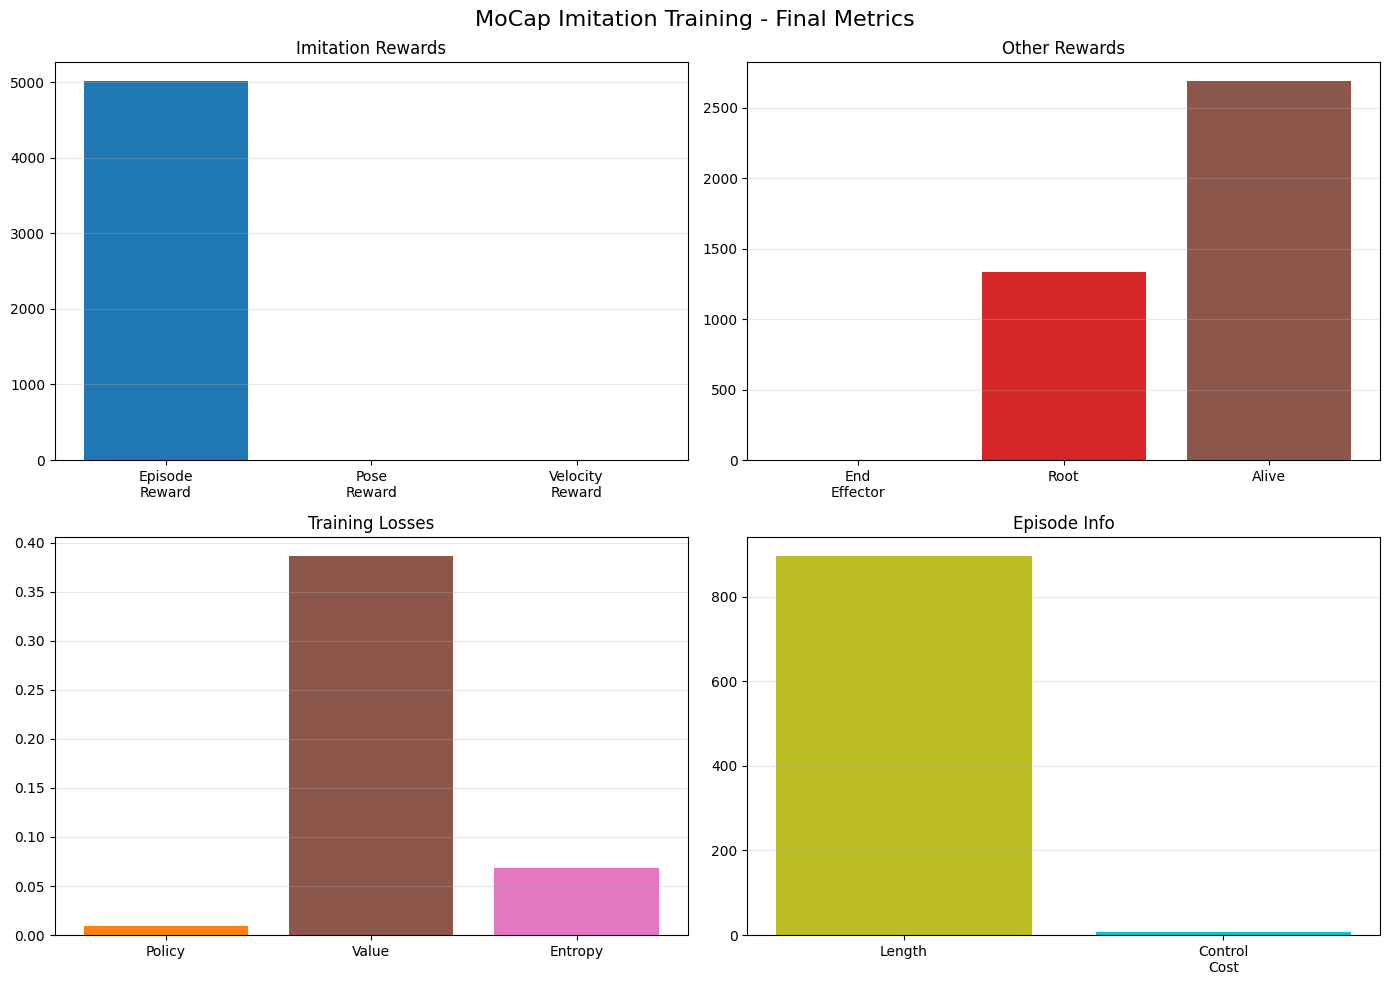

In [14]:
# Plot MoCap Training Metrics

import matplotlib.pyplot as plt
import numpy as np

print("📊 MoCap Training Metrics Summary")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('MoCap Imitation Training - Final Metrics', fontsize=16)

# Extract scalar metrics
scalar_metrics = {}
for key, values in mocap_metrics.items():
    if hasattr(values, '__array__'):
        values = np.asarray(values)
    if isinstance(values, np.ndarray):
        if values.ndim == 0 or values.size == 1:
            scalar_metrics[key] = float(values)
    else:
        scalar_metrics[key] = values

# Plot 1: Episode Performance
ax1 = axes[0, 0]
performance = {
    'Episode\nReward': scalar_metrics.get('eval/episode_reward', 0),
    'Pose\nReward': scalar_metrics.get('eval/episode_pose_reward', 0),
    'Velocity\nReward': scalar_metrics.get('eval/episode_velocity_reward', 0),
}
ax1.bar(range(len(performance)), list(performance.values()), color=['#1f77b4', '#2ca02c', '#ff7f0e'])
ax1.set_xticks(range(len(performance)))
ax1.set_xticklabels(list(performance.keys()))
ax1.set_title('Imitation Rewards')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Other Rewards
ax2 = axes[0, 1]
other_rewards = {
    'End\nEffector': scalar_metrics.get('eval/episode_end_effector_reward', 0),
    'Root': scalar_metrics.get('eval/episode_root_reward', 0),
    'Alive': scalar_metrics.get('eval/episode_reward_alive', 0),
}
ax2.bar(range(len(other_rewards)), list(other_rewards.values()), color=['#9467bd', '#d62728', '#8c564b'])
ax2.set_xticks(range(len(other_rewards)))
ax2.set_xticklabels(list(other_rewards.keys()))
ax2.set_title('Other Rewards')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Training Losses
ax3 = axes[1, 0]
losses = {
    'Policy': abs(scalar_metrics.get('training/policy_loss', 0)),
    'Value': scalar_metrics.get('training/v_loss', 0),
    'Entropy': abs(scalar_metrics.get('training/entropy_loss', 0)),
}
ax3.bar(range(len(losses)), list(losses.values()), color=['#ff7f0e', '#8c564b', '#e377c2'])
ax3.set_xticks(range(len(losses)))
ax3.set_xticklabels(list(losses.keys()))
ax3.set_title('Training Losses')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Episode Info
ax4 = axes[1, 1]
episode_info = {
    'Length': scalar_metrics.get('eval/avg_episode_length', 0),
    'Control\nCost': abs(scalar_metrics.get('eval/episode_reward_ctrl', 0)),
}
ax4.bar(range(len(episode_info)), list(episode_info.values()), color=['#bcbd22', '#17becf'])
ax4.set_xticks(range(len(episode_info)))
ax4.set_xticklabels(list(episode_info.keys()))
ax4.set_title('Episode Info')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_metrics_mocap.png', dpi=150)
print("✓ Saved training metrics to 'training_metrics_mocap.png'")
plt.show()